In [283]:
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model

## Aspiration Threshold Calculation

In [2]:
raw_cvfs = pd.read_table('CVFS_Data_001.tsv')
raw_cvfs.replace(' ',0, inplace=True)
clean_cvfs = pd.DataFrame()
clean_cvfs['HHID'] = raw_cvfs['HHID']

# removing end years 63 and 72 due to inconsistency
p = re.compile('B1[1-3][bc]_(6[4-9]|7[0-1])', re.IGNORECASE)

for item in raw_cvfs.columns:    
    match = p.match(item)
    if bool(match):
        clean_cvfs[item] = raw_cvfs[item].astype(float)

pivot_cvfs = pd.wide_to_long(clean_cvfs, ['B11B','B11C','B12B','B12C','B13B','B13C'], i='HHID', j='Year', sep='_')

rupees_produced = pd.DataFrame()
rupees_produced['Rice'] = (pivot_cvfs['B11B']-pivot_cvfs['B11C'])*24 #24 rupees/kg rice
rupees_produced['Maize'] = (pivot_cvfs['B12B']-pivot_cvfs['B12C'])*23 #23 rupees/kg maize
rupees_produced['Wheat'] = (pivot_cvfs['B13B']-pivot_cvfs['B13C'])*21 #21 rupees/kg wheat

total_rupees = rupees_produced.mean(axis=0).sum()

(total_rupees*0.01)/2 #Nepalese rupee to USD conversion rate ~0.01

c:\users\kyan3\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,48,49,50,51,52,53,58,59,60,61,62,63,68,69,70,71,72,73,78,79,80,81,82,83,88,89,90,91,92,93,98,99,100,101,102,103,108,109,110,111,112,113,118,119,120,121,122,123,128,129,130,131,132,133,168,169,170,171,172,173,208,209,210,211,212,213,248,249,250,251,252,253,288,289,290,291,292,293,328,329,330,331,332,333,358,359,360,361,362,363,388,389,390,391,392,393,418,419,420,421,422,423,448,449,450,451,452,453,478,479,480,481,482,483,508,509,510,511,512,513,538,539,540,541,542,543,578,579,580,581,582,583,588,589,590,591,592,593,598,599,600,601,602,603,608,609,610,611,612,613,618,619,620,621,622,623,628,629,630,631,632,633,638,639,640,641,642,643,648,649,650,651,652,653,654,655,656,668,669,670,671,672,673,678,679,680,681,682,683,688,689,690,691,692,693,698,699,700,701,702,703,708,709,710,711,712,713,738,739,740,741,742,743,786) have mixed types.Specif

102.71197727272727

## Correlation of Crop Area Planted with Previous Yields

In [27]:
raw_cvfs = pd.read_table('CVFS_Data_001.tsv')
raw_cvfs.replace(' ',0, inplace=True)

c:\users\kyan3\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,48,49,50,51,52,53,58,59,60,61,62,63,68,69,70,71,72,73,78,79,80,81,82,83,88,89,90,91,92,93,98,99,100,101,102,103,108,109,110,111,112,113,118,119,120,121,122,123,128,129,130,131,132,133,168,169,170,171,172,173,208,209,210,211,212,213,248,249,250,251,252,253,288,289,290,291,292,293,328,329,330,331,332,333,358,359,360,361,362,363,388,389,390,391,392,393,418,419,420,421,422,423,448,449,450,451,452,453,478,479,480,481,482,483,508,509,510,511,512,513,538,539,540,541,542,543,578,579,580,581,582,583,588,589,590,591,592,593,598,599,600,601,602,603,608,609,610,611,612,613,618,619,620,621,622,623,628,629,630,631,632,633,638,639,640,641,642,643,648,649,650,651,652,653,654,655,656,668,669,670,671,672,673,678,679,680,681,682,683,688,689,690,691,692,693,698,699,700,701,702,703,708,709,710,711,712,713,738,739,740,741,742,743,786) have mixed types.Specif

In [90]:
clean_cvfs = raw_cvfs.filter(regex='HHID|B1[1-3][AB]_(6[3-9]|7[0-2])',axis=1)

In [307]:
clean_cvfs.filter(regex='B1[1-3]B_'+str(year),axis=1).astype(float).sum(axis=1)

0        500.0
1        100.0
2        300.0
3          0.0
4        250.0
         ...  
2250      95.0
2251       0.0
2252    1000.0
2253       0.0
2254     350.0
Length: 2255, dtype: float64

In [348]:
area_cvfs = pd.DataFrame()
production_cvfs = pd.DataFrame()

area_cvfs['HHID'] = clean_cvfs['HHID']
production_cvfs['HHID'] = clean_cvfs['HHID']
for year in range(64,73):
    area_cvfs[year] = clean_cvfs.filter(regex='B1[1-3]A_'+str(year),axis=1).astype(float).sum(axis=1)
    production_cvfs[year] = clean_cvfs.filter(regex='B1[1-3]B_'+str(year),axis=1).astype(float).sum(axis=1)

In [349]:
area_long_cvfs = pd.melt(area_cvfs, id_vars=['HHID'],var_name='Year',value_name='Area')
production_long_cvfs = pd.melt(production_cvfs, id_vars=['HHID'],var_name='Year',value_name='Production')

In [350]:
lag1_cvfs = pd.DataFrame()
lag1_cvfs['Area'] = area_long_cvfs[area_long_cvfs['Year']>64]['Area'].array
lag1_cvfs['Production_Lag_1'] = production_long_cvfs[production_long_cvfs['Year']<72]['Production'].array

lag2_cvfs = pd.DataFrame()
lag2_cvfs['Area'] = area_long_cvfs[area_long_cvfs['Year']>65]['Area'].array
lag2_cvfs['Production_Lag_1'] = production_long_cvfs[production_long_cvfs['Year'].between(65,71,inclusive=True)]['Production'].array
lag2_cvfs['Production_Lag_2'] = production_long_cvfs[production_long_cvfs['Year'].between(64,70,inclusive=True)]['Production'].array

lag3_cvfs = pd.DataFrame()
lag3_cvfs['Area'] = area_long_cvfs[area_long_cvfs['Year']>66]['Area'].array
lag3_cvfs['Production_Lag_1'] = production_long_cvfs[production_long_cvfs['Year'].between(66,71,inclusive=True)]['Production'].array
lag3_cvfs['Production_Lag_2'] = production_long_cvfs[production_long_cvfs['Year'].between(65,70,inclusive=True)]['Production'].array
lag3_cvfs['Production_Lag_3'] = production_long_cvfs[production_long_cvfs['Year'].between(64,69,inclusive=True)]['Production'].array

lag4_cvfs = pd.DataFrame()
lag4_cvfs['Area'] = area_long_cvfs[area_long_cvfs['Year']>67]['Area'].array
lag4_cvfs['Production_Lag_1'] = production_long_cvfs[production_long_cvfs['Year'].between(67,71,inclusive=True)]['Production'].array
lag4_cvfs['Production_Lag_2'] = production_long_cvfs[production_long_cvfs['Year'].between(66,70,inclusive=True)]['Production'].array
lag4_cvfs['Production_Lag_3'] = production_long_cvfs[production_long_cvfs['Year'].between(65,69,inclusive=True)]['Production'].array
lag4_cvfs['Production_Lag_4'] = production_long_cvfs[production_long_cvfs['Year'].between(64,68,inclusive=True)]['Production'].array

lag5_cvfs = pd.DataFrame()
lag5_cvfs['Area'] = area_long_cvfs[area_long_cvfs['Year']>68]['Area'].array
lag5_cvfs['Production_Lag_1'] = production_long_cvfs[production_long_cvfs['Year'].between(68,71,inclusive=True)]['Production'].array
lag5_cvfs['Production_Lag_2'] = production_long_cvfs[production_long_cvfs['Year'].between(67,70,inclusive=True)]['Production'].array
lag5_cvfs['Production_Lag_3'] = production_long_cvfs[production_long_cvfs['Year'].between(66,69,inclusive=True)]['Production'].array
lag5_cvfs['Production_Lag_4'] = production_long_cvfs[production_long_cvfs['Year'].between(65,68,inclusive=True)]['Production'].array
lag5_cvfs['Production_Lag_5'] = production_long_cvfs[production_long_cvfs['Year'].between(64,67,inclusive=True)]['Production'].array

In [351]:
X_1 = lag1_cvfs.iloc[:,-1].values.reshape(-1,1)
Y_1 = lag1_cvfs.iloc[:,-2].values.reshape(-1,1)

reg_1 = sm.OLS(Y_1, X_1).fit()
reg_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.779
Model:                            OLS   Adj. R-squared (uncentered):              0.779
Method:                 Least Squares   F-statistic:                          6.354e+04
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:17:34   Log-Likelihood:                         -69795.
No. Observations:               18040   AIC:                                  1.396e+05
Df Residuals:                   18039   BIC:                                  1.396e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0103   4.08e-05    252.065      0.000       0.010       0.010
==============================================================================
Omnibus:                     6860.124   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           426059.264
Skew:                           1.007   Prob(JB):                         0.00
Kurtosis:                      26.723   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

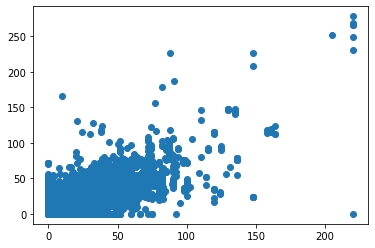

In [352]:
predict_1 = reg_1.predict(X_1)
plt.scatter(Y_1,predict_1)

In [353]:
X_2 = lag2_cvfs.iloc[:,-2:].values.reshape(-1,2)
Y_2 = lag2_cvfs.iloc[:,-3].values.reshape(-1,1)

reg_2 = sm.OLS(Y_2, X_2).fit()
reg_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.781
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                          2.812e+04
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:18:06   Log-Likelihood:                         -60782.
No. Observations:               15785   AIC:                                  1.216e+05
Df Residuals:                   15783   BIC:                                  1.216e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0089      0.000     57.390      0.000       0.009       0.009
x2             0.0013      0.000      8.497      0.000       0.001       0.002
==============================================================================
Omnibus:                     4619.543   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147124.801
Skew:                           0.771   Prob(JB):                         0.00
Kurtosis:                      17.877   Cond. No.                         7.09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [354]:
X_3 = lag3_cvfs.iloc[:,-3:].values.reshape(-1,3)
Y_3 = lag3_cvfs.iloc[:,-4].values.reshape(-1,1)

reg_3 = sm.OLS(Y_3, X_3).fit()
reg_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.775
Model:                            OLS   Adj. R-squared (uncentered):              0.775
Method:                 Least Squares   F-statistic:                          1.552e+04
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:18:10   Log-Likelihood:                         -52088.
No. Observations:               13530   AIC:                                  1.042e+05
Df Residuals:                   13527   BIC:                                  1.042e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0085      0.000     48.716      0.000       0.008       0.009
x2             0.0010      0.000      4.261      0.000       0.001       0.001
x3             0.0006      0.000      3.623      0.000       0.000       0.001
==============================================================================
Omnibus:                     4018.980   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119370.089
Skew:                           0.813   Prob(JB):                         0.00
Kurtosis:                      17.460   Cond. No.                         10.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [281]:
X_4 = lag4_cvfs.iloc[:,-4:].values.reshape(-1,4)
Y_4 = lag4_cvfs.iloc[:,-5].values.reshape(-1,1)

reg_4 = sm.OLS(Y_4, X_4).fit()
reg_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.772
Method:                 Least Squares   F-statistic:                              9556.
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                        0.00
Time:                        16:47:50   Log-Likelihood:                         -43267.
No. Observations:               11275   AIC:                                  8.654e+04
Df Residuals:                   11271   BIC:                                  8.657e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0084      0.000     46.016      0.000       0.008       0.009
x2             0.0009      0.000      3.539      0.000       0.000       0.001
x3            -0.0005      0.000     -2.047      0.041      -0.001   -2.15e-05
x4             0.0012      0.000      6.911      0.000       0.001       0.002
==============================================================================
Omnibus:                     3322.537   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70739.174
Skew:                           0.900   Prob(JB):                         0.00
Kurtosis:                      15.138   Cond. No.                         12.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [282]:
X_5 = lag5_cvfs.iloc[:,-5:].values.reshape(-1,5)
Y_5 = lag5_cvfs.iloc[:,-6].values.reshape(-1,1)

reg_5 = sm.OLS(Y_5, X_5).fit()
reg_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.767
Model:                            OLS   Adj. R-squared (uncentered):              0.767
Method:                 Least Squares   F-statistic:                              5941.
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                        0.00
Time:                        16:48:17   Log-Likelihood:                         -34554.
No. Observations:                9020   AIC:                                  6.912e+04
Df Residuals:                    9015   BIC:                                  6.915e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0081      0.000     39.623      0.000       0.008       0.009
x2             0.0010      0.000      3.730      0.000       0.000       0.002
x3            -0.0005      0.000     -1.951      0.051      -0.001    2.48e-06
x4             0.0015      0.000      5.341      0.000       0.001       0.002
x5            -0.0002      0.000     -0.963      0.336      -0.001       0.000
==============================================================================
Omnibus:                     2329.796   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43549.085
Skew:                           0.761   Prob(JB):                         0.00
Kurtosis:                      13.656   Cond. No.                         13.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [343]:
lm = linear_model.LinearRegression()
model1 = lm.fit(X_1,Y_1)

In [344]:
pred1 = lm.predict(X_1)

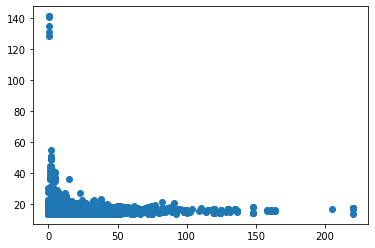

In [346]:
fig, ax = plt.subplots()
ax.scatter(Y_1,pred1)